## 1: CRF sequence tagging for Movie Queries
This coursework involves optimizing the performance of a Conditional Random Field (CRF) sequence tagger for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a BIO (Beginning, Inside, Outside) tagging format.
This assignment involves reading in, pre-processing, training and developing my tagger on the training data from trivia10k13train.bio.txt, and finally testing my tagger on the data trivia10k13test.bio.txt, attempting to get the best performing tagger across the different labels in my development process. 

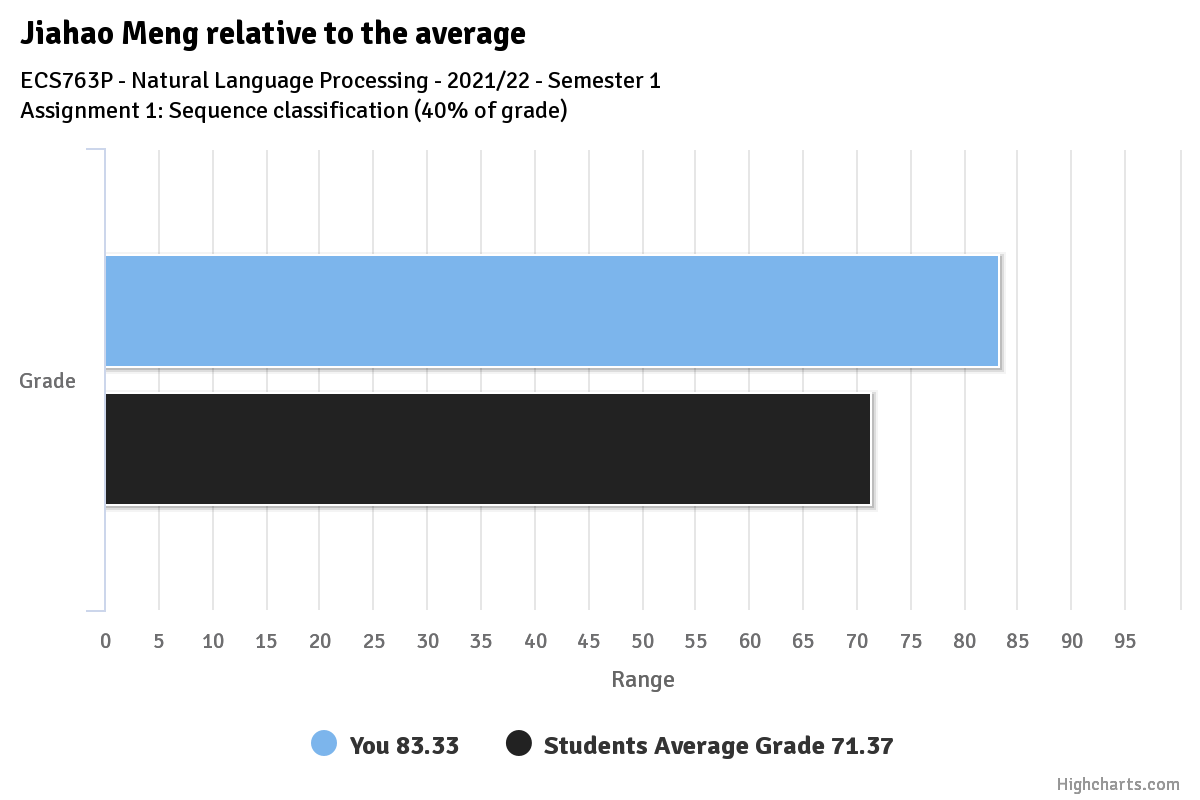

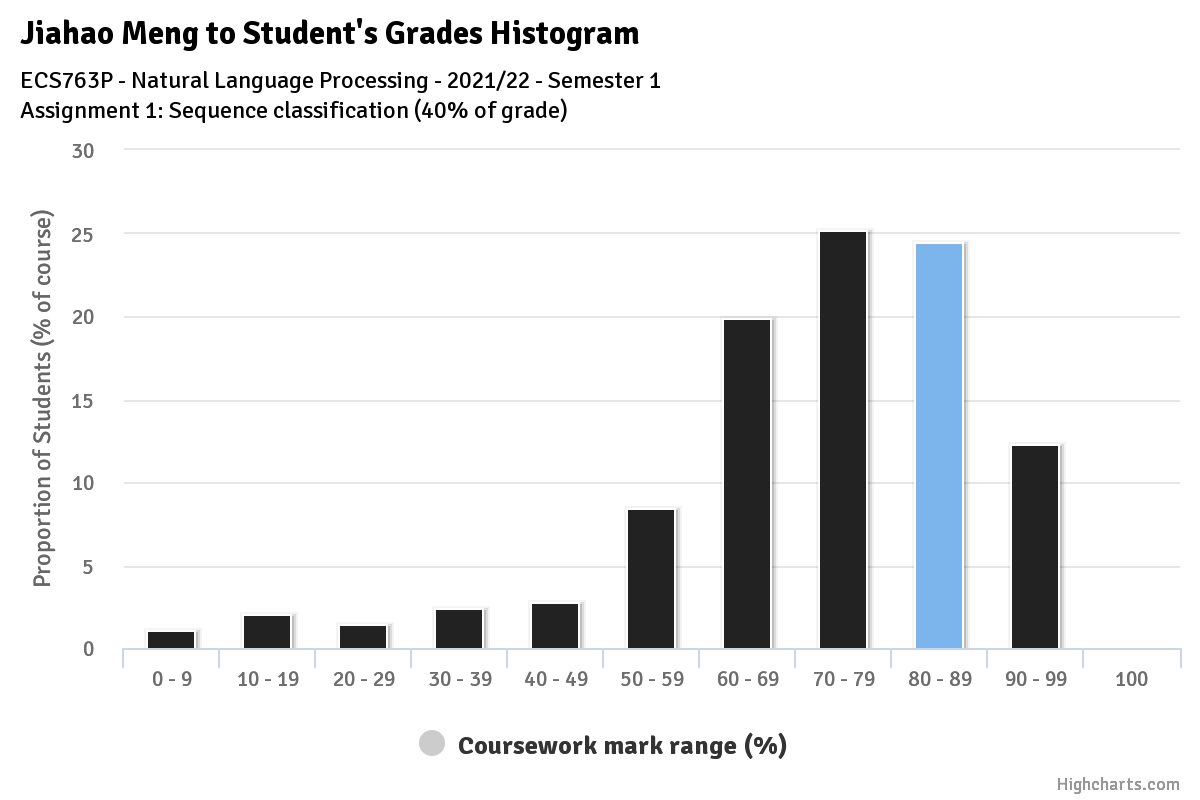

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
#imput the data
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [3]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [4]:
def preProcess(example):
    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [5]:
# check the effect of pre-processing
# we should have words and CRF tag
training_data = [preProcess(example) for example in raw_training_data]
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
# Heatmap for confusion matrix

def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

In [7]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
        
    feature_list.append("WORD_" + token)
    # print(feature_list)
    return feature_list

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which I will use for training my CRF, and the remaining 20% for testing. Once I've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and obtain the classification report output and confusion heatmap output for the results of testing. 



In [8]:
# split the data
from sklearn.model_selection import train_test_split
train_q1, test_q1 = train_test_split(training_data, test_size=0.2, random_state=0)
print ("the percentage of train data is {0}, the percentage of test data is {1},"
       .format(len(train_q1)/len(training_data)*100, len(test_q1)/len(training_data)*100))

# Train the CRF BIO-tag tagger again
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func = get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_q1, TAGGER_PATH)
print("done")

the percentage of train data is 79.98976458546572, the percentage of test data is 20.01023541453429,
training tagger...
done


- now the feature_list is like:

```['WORD_what']
['WORD_s']
['WORD_that']
['WORD_newer']```

In [9]:
print("testing tagger...")
preds_q1 = []
y_test_q1 = []
for sent in test_q1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q1.extend(sent_preds)
    y_test_q1.extend(sent_true)
print("done")

testing tagger...
done


In [10]:
import pandas as pd
report_q1 = classification_report(y_test_q1, preds_q1, output_dict=True)
report_q1 = pd.DataFrame(report_q1).transpose()
print (report_q1)

/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score       support
B-Actor            0.878879  0.854086  0.866305   1028.000000
B-Award            0.780000  0.600000  0.678261     65.000000
B-Character_Name   0.733333  0.056410  0.104762    195.000000
B-Director         0.873188  0.604010  0.714074    399.000000
B-Genre            0.839286  0.739628  0.786312    699.000000
B-Opinion          0.460000  0.321678  0.378601    143.000000
B-Origin           0.412844  0.276074  0.330882    163.000000
B-Plot             0.466238  0.460683  0.463444   1259.000000
B-Quote            0.800000  0.250000  0.380952     32.000000
B-Relationship     0.775862  0.387931  0.517241    116.000000
B-Soundtrack       0.000000  0.000000  0.000000     15.000000
B-Year             0.928693  0.956294  0.942291    572.000000
I-Actor            0.872590  0.813281  0.841892   1280.000000
I-Award            0.761589  0.766667  0.764120    150.000000
I-Character_Name   0.538462  0.053435  0.097222    131.000000
I-Direct

/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'I-Director', 'I-Soundtrack', 'I-Relationship', 'I-Year', 'I-Quote', 'B-Origin', 'I-Genre', 'I-Character_Name', 'B-Actor', 'I-Award', 'B-Quote', 'B-Award', 'B-Soundtrack', 'B-Opinion', 'I-Origin', 'B-Relationship', 'I-Opinion', 'I-Actor', 'B-Year', 'B-Genre', 'B-Character_Name', 'I-Plot', 'B-Plot', 'B-Director'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


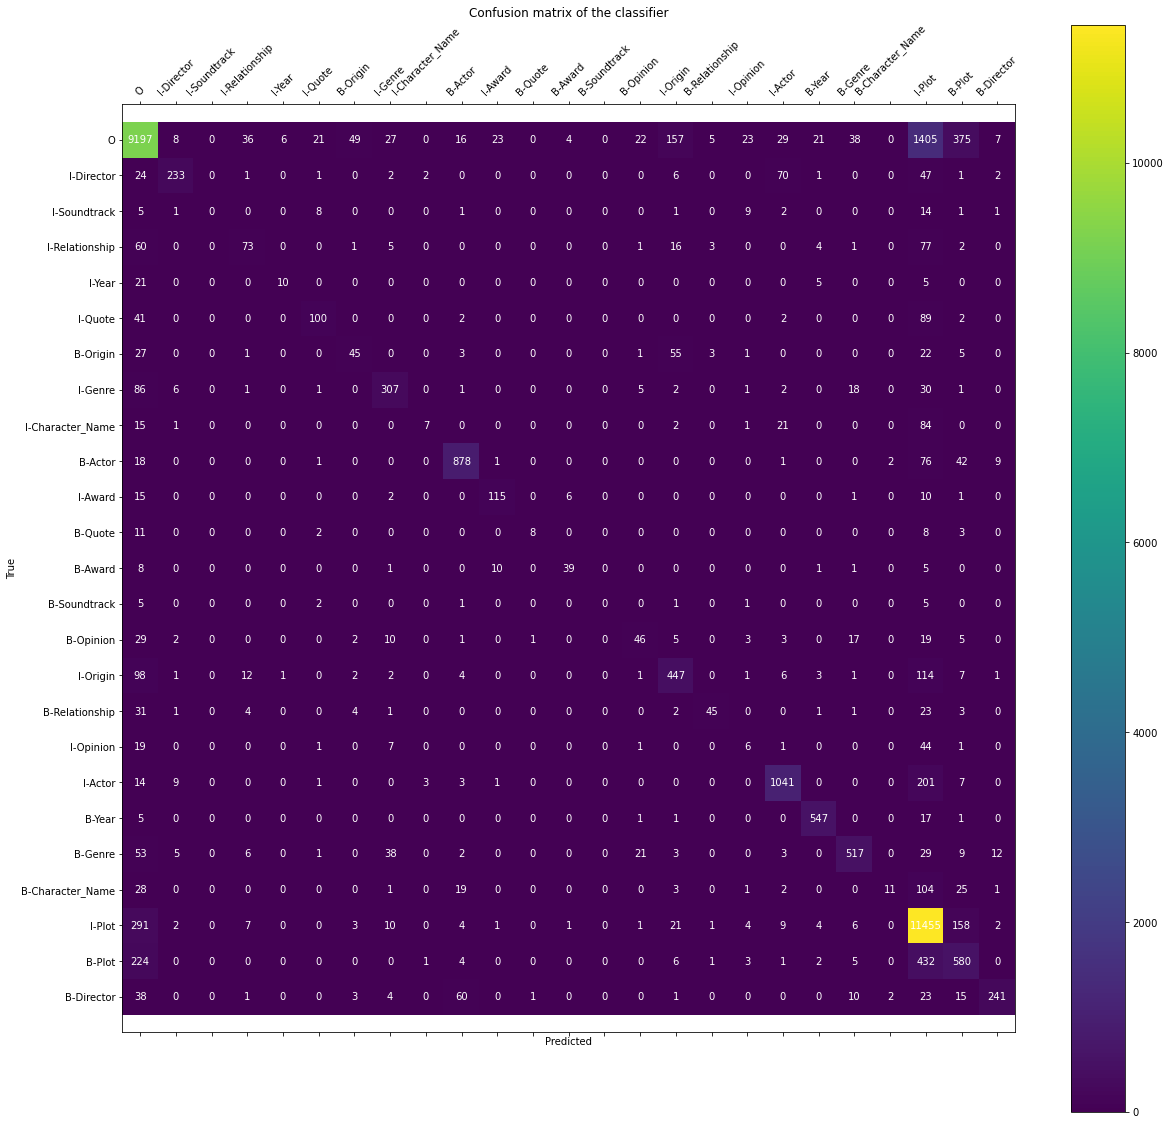

In [11]:
confusion_matrix_heatmap(y_test_q1, preds_q1)

# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving my NLP applications. For the 5 classes which have the lowest precision, according to the results table from my 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word).

In [12]:
# find the 5 lowest precision
target_categories_q2 = []
for i in report_q1.sort_values('precision')[:5].index:
    target_categories_q2.append(i)
print (target_categories_q2)

['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Origin', 'B-Opinion']


In [13]:
### print("testing tagger...")
preds_q2 = []
y_test_q2 = []

# set a counter for validation
fp_count = {}
for cate in target_categories_q2:
    fp_count[cate] = 0
    
for sent in test_q1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q2.extend(sent_preds)
    y_test_q2.extend(sent_true)



# Find the FP:

# FP is for the prediction
    for i in range(len(sent_true)):
        if sent_preds[i] not in target_categories_q2: 
            continue
        if sent_preds[i] == sent_true[i]:
            continue
        print('FP for prediction {0} (one word is misclassified to {1}): \n'.format(sent_preds[i], sent_true[i]))

# Counter for FP

            
        if sent_preds[i] in fp_count:
            fp_count[sent_preds[i]] += 1
        else:
            fp_count[sent_preds[i]] = 1    
        
# Print the sentence
        sentence = []
        for sen in sent:
            sentence.append(sen[0])
        print ('The entire sentence is ',sentence)
        print ('\n')
        
print(fp_count)
print("done")

FP for prediction B-Origin (one word is misclassified to B-Director): 

The entire sentence is  ['what', 'is', 'the', 'movie', 'that', 'is', 'based', 'off', 'of', 'shakespeare', 's', 'play', 'in', 'which', 'the', 'main', 'character', 'has', 'the', 'to', 'be', 'or', 'not', 'to', 'be', 'monologue']


FP for prediction B-Opinion (one word is misclassified to O): 

The entire sentence is  ['which', 'film', 'is', 'walt', 'disney', 's', 'experimental', 'masterpiece', 'in', 'which', 'animated', 'images', 'are', 'set', 'to', 'pieces', 'of', 'classical', 'music']


FP for prediction B-Opinion (one word is misclassified to B-Genre): 

The entire sentence is  ['i', 'am', 'thinking', 'of', 'the', 'classic', 'live', 'action', 'children', 's', 'film', 'that', 'tells', 'the', 'story', 'of', 'a', 'boy', 'who', 'wins', 'a', 'golden', 'ticket', 'to', 'go', 'on', 'a', 'sweet', 'tour']


FP for prediction B-Origin (one word is misclassified to O): 

The entire sentence is  ['what', 's', 'the', 'movie', 'b

In [14]:
# convert confusion matrix to dataframe for validation
cm_label = list(set(y_test_q1))
cm = confusion_matrix(y_test_q1, preds_q1, labels = cm_label)
cm = pd.DataFrame(cm, index= cm_label, columns = cm_label)

In [15]:
# count FP in confusion matrix
fp_valid = {}
for i in target_categories_q2:
    fp_valid[i] = cm.sum(axis=0)[i] - cm[i][i]

print (fp_valid)

{'I-Soundtrack': 0, 'B-Soundtrack': 0, 'I-Opinion': 48, 'B-Origin': 64, 'B-Opinion': 54}


In [16]:
# Validation for the FP output via confusion matrix
# if the frequency of output is same as the number in matrix
# it works

print ('The FP counter works available:', fp_valid == fp_count)

The FP counter works available: True


# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from my 20% development data, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger).

In [17]:
# find the 5 lowest recall
target_categories_q3 = []
for i in report_q1.sort_values('recall')[:5].index:
    target_categories_q3.append(i)

print (target_categories_q3)

['I-Soundtrack', 'B-Soundtrack', 'I-Character_Name', 'B-Character_Name', 'I-Opinion']


In [18]:
print("testing tagger...")
preds_q3 = []
y_test_q3 = []

# set a counter 
fn_count = {}
for cate in target_categories_q3:
    fn_count[cate] = 0

for sent in test_q1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q3.extend(sent_preds)
    y_test_q3.extend(sent_true)

# Find the FN:
# FN is for the actual label

    for i in range(len(sent_true)):
        if sent_true[i] not in target_categories_q3: 
            continue
        if sent_preds[i] == sent_true[i]:
            continue
        print('FN for label {0} (which misclassified to {1}): \\n'.format(sent_true[i], sent_preds[i]))
        sentence = []

# Counter for FN
        if sent_true[i] in fn_count:
            fn_count[sent_true[i]] += 1
        else:
            fn_count[sent_true[i]] = 1  
        
# Print the sentence
        for sen in sent:
            sentence.append(sen[0])
        print ('The entire sentence is ',sentence)
        print ('\n')
        

print("done")
print(fn_count)

testing tagger...
FN for label B-Character_Name (which misclassified to B-Plot): \n
The entire sentence is  ['in', 'what', 'movie', 'is', 'batman', 'forced', 'to', 'choose', 'between', 'rachel', 'his', 'friend', 'and', 'gotham', 's', 'future', 'harvey', 'dent']


FN for label B-Character_Name (which misclassified to I-Plot): \n
The entire sentence is  ['in', 'what', 'movie', 'is', 'batman', 'forced', 'to', 'choose', 'between', 'rachel', 'his', 'friend', 'and', 'gotham', 's', 'future', 'harvey', 'dent']


FN for label B-Character_Name (which misclassified to I-Plot): \n
The entire sentence is  ['in', 'what', 'movie', 'is', 'batman', 'forced', 'to', 'choose', 'between', 'rachel', 'his', 'friend', 'and', 'gotham', 's', 'future', 'harvey', 'dent']


FN for label I-Character_Name (which misclassified to I-Plot): \n
The entire sentence is  ['in', 'what', 'movie', 'is', 'batman', 'forced', 'to', 'choose', 'between', 'rachel', 'his', 'friend', 'and', 'gotham', 's', 'future', 'harvey', 'dent']


The entire sentence is  ['what', 'is', 'the', 'name', 'of', 'the', '2000', 'holiday', 'family', 'movie', 'that', 'features', 'a', 'character', 'named', 'martha', 'may', 'whoiver']


FN for label I-Character_Name (which misclassified to I-Plot): \n
The entire sentence is  ['what', 'is', 'the', 'name', 'of', 'the', '2000', 'holiday', 'family', 'movie', 'that', 'features', 'a', 'character', 'named', 'martha', 'may', 'whoiver']


FN for label B-Character_Name (which misclassified to I-Plot): \n
The entire sentence is  ['mel', 'gibson', 'initially', 'turned', 'down', 'the', 'role', 'of', 'william', 'wallace', 'because', 'he', 'felt', 'he', 'was', 'too', 'old', 'for', 'the', 'part', 'in', 'this', '1995', 'oscar', 'winner']


FN for label I-Character_Name (which misclassified to I-Plot): \n
The entire sentence is  ['mel', 'gibson', 'initially', 'turned', 'down', 'the', 'role', 'of', 'william', 'wallace', 'because', 'he', 'felt', 'he', 'was', 'too', 'old', 'for', 'the', 'part', 'in', 'this', '

In [19]:
# count FN in confusion matrix
fn_valid = {}
for i in target_categories_q3:
    fn_valid[i] = cm.sum(axis=1)[i] - cm[i][i]

print (fn_valid)

{'I-Soundtrack': 43, 'B-Soundtrack': 15, 'I-Character_Name': 124, 'B-Character_Name': 184, 'I-Opinion': 74}


In [20]:
# Validation for the FN output via confusion matrix
# if the frequency of output is same as the number in matrix
# it works

print ('The FN counter works available:', fn_valid == fn_count)

The FN counter works available: True


# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so I will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and I will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on my 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvments across the classes.

In [21]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [22]:
# concatenate the word and POS tag together with @
def preProcess_new(example):
    new_temp1 = []
    for word in example:
        new_test = []
        temp = posttagger.tag([word[0]])

        for i in temp:
            new_temp1.append((i[0]+'@'+i[1], word[1])) 
        new_test.append(new_temp1)
    return new_temp1

In [23]:
# test the preProcess_new
preProcess_new([('steve', 'B-Actor')])

[('steve@PRPVBP', 'B-Actor')]

In [24]:
training_data_q4 = [preProcess_new(example) for example in raw_training_data]
train_q4, test_q4 = train_test_split(training_data_q4, test_size=0.2, random_state=0)

In [25]:
# uses the POS tag in addition to the word
_pattern = re.compile(r"\d") 
def get_features_new(tokens, idx):
    
    token_tag = tokens[idx]
    token = token_tag.split("@")[0]


    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + token_tag.split("@")[1])
    # print(feature_list)
    return feature_list

In [26]:
##### TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func = get_features_new)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_q4, TAGGER_PATH)
print("done")

training tagger...
done


- now the feature_list is like:

```['WORD_what', 'POS_WP']
['WORD_s', 'POS_BES']
['WORD_that', 'POS_WDT']
['WORD_newer', 'POS_JJR']
['WORD_movie', 'POS_NN']
['WORD_that', 'POS_WDT']
['WORD_quentin', 'POS_NN']```

In [27]:
print("testing tagger...")
preds_q4 = []
y_test_q4 = []
for sent in test_q4:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q4.extend(sent_preds)
    y_test_q4.extend(sent_true)
    
print("done")

testing tagger...
done


In [28]:
report_q4 = classification_report(y_test_q4, preds_q4, output_dict=True)
report_q4 = pd.DataFrame(report_q4).transpose()
print (report_q4)

/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score       support
B-Actor            0.842991  0.877432  0.859867   1028.000000
B-Award            0.816327  0.615385  0.701754     65.000000
B-Character_Name   0.823529  0.071795  0.132075    195.000000
B-Director         0.838284  0.636591  0.723647    399.000000
B-Genre            0.839744  0.749642  0.792139    699.000000
B-Opinion          0.470000  0.328671  0.386831    143.000000
B-Origin           0.405405  0.276074  0.328467    163.000000
B-Plot             0.487285  0.471803  0.479419   1259.000000
B-Quote            0.636364  0.218750  0.325581     32.000000
B-Relationship     0.790323  0.422414  0.550562    116.000000
B-Soundtrack       0.000000  0.000000  0.000000     15.000000
B-Year             0.933219  0.952797  0.942907    572.000000
I-Actor            0.849462  0.864062  0.856700   1280.000000
I-Award            0.773333  0.773333  0.773333    150.000000
I-Character_Name   0.750000  0.091603  0.163265    131.000000
I-Direct

In [29]:
# find whether the score is higher or lower
report_q4 - report_q1

,precision,recall,f1-score,support
B-Actor,-0.035888,0.023346,-0.006438,0.000000
B-Award,0.036327,0.015385,0.023494,0.000000
B-Character_Name,0.090196,0.015385,0.027314,0.000000
B-Director,-0.034905,0.032581,0.009573,0.000000
B-Genre,0.000458,0.010014,0.005827,0.000000
B-Opinion,0.010000,0.006993,0.008230,0.000000
B-Origin,-0.007439,0.000000,-0.002415,0.000000
B-Plot,0.021047,0.011120,0.015975,0.000000
B-Quote,-0.163636,-0.031250,-0.055371,0.000000
B-Relationship,0.014461,0.034483,0.033320,0.000000


- All of accuracy, macro avg, weighted avg are higher.

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on my 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure I describe this in my report.

Feature tips: I could try more suffixes/prefixes of the current word than those currently extracted, I could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As I try different feature functions, use the techniques I used in Q2 and Q3 to see the kind of errors I are getting for lower performing classes, in addition to the confusion matrix over classes.

1. More Suffix
1. More Prefixes
1. More Previous Words
1. More Next Words

## More Suffixes

In [30]:
train_q5, test_q5 = train_test_split(training_data_q4, test_size=0.2, random_state=0)

In [31]:
# score summary list
score_suf = []

In [32]:
_pattern = re.compile(r"\d") 
def get_features_q5(tokens, idx):

    
    token_tag = tokens[idx]
    token = token_tag.split("@")[0]

    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")


        
# Suffix up to max_suf (max_suf must be <= len(token) 
    max_suf = 9        
    if max_suf > len(token):
        max_suf = len(token)              
    for s in range(max_suf):
        if len(token) > (s+1):
            feature_list.append("SUF_" + token[-s-1:])
            
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" +token_tag.split("@")[1])
    # print(feature_list)
    return feature_list

- now the feature_list looks like:

```['SUF_e', 'SUF_he', 'WORD_the', 'POS_DT']
['SUF_n', 'SUF_rn', 'SUF_ern', 'SUF_dern', 'WORD_modern', 'POS_JJ']```

In [33]:
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func = get_features_q5)  
print("training tagger...")
ct.train(train_q5, TAGGER_PATH)
print("done")
print("testing tagger...")
preds_q5 = []
y_test_q5 = []
for sent in test_q5:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q5.extend(sent_preds)
    y_test_q5.extend(sent_true)
print("done")

#focus on macro avg f1 score
report_q5 = classification_report(y_test_q5, preds_q5, output_dict=True)
report_q5 = pd.DataFrame(report_q5).transpose()
score = report_q5[report_q5.index == ('macro avg')]['f1-score']
score_suf.append(score)

print (score_suf)

training tagger...
done
testing tagger...
done
[macro avg    0.60328
Name: f1-score, dtype: float64]


if we loop the function with different max_suf, we can get
these results for score_suf, which saved every result as a list.

```[macro avg    0.552673 Name: f1-score, dtype: float64, 
macro avg    0.551488 Name: f1-score, dtype: float64, 
macro avg    0.562267 Name: f1-score, dtype: float64, 
macro avg    0.587537 Name: f1-score, dtype: float64, 
macro avg    0.598782 Name: f1-score, dtype: float64, 
macro avg    0.603487 Name: f1-score, dtype: float64, 
macro avg    0.602201 Name: f1-score, dtype: float64, 
macro avg    0.601061 Name: f1-score, dtype: float64, 
macro avg    0.60328 Name: f1-score, dtype: float64]```

As we can see, the best result is 6th: 0.603487

## More Prefixes

In [34]:
score_pre = []

In [35]:
# uses the POS tag in addition to the word
_pattern = re.compile(r"\d") 
def get_features_q5_pre(tokens, idx):
    #print(idx)
    
    token_tag = tokens[idx]
    token = token_tag.split("@")[0]


    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

# Suffix up to max_suf (max_suf must be <= len(token) 
    max_suf = 6           
    if max_suf > len(token):
        max_suf = len(token)              
    for s in range(max_suf):
        if len(token) > (s+1):
            feature_list.append("SUF_" + token[-s-1:])
        
        
# Prefix up to length p (p <= len(token))
    p = 9;
    if p > len(token):
        for i in range(len(token)):
            feature_list.append("Pre_" + token[:i+1])
    else:
        for i in range(p):
            feature_list.append("Pre_" + token[:i+1])
    
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" +token_tag.split("@")[1])
    # print(feature_list)
    return feature_list

- now feature_list looks like:

```['SUF_t', 'SUF_at', 'SUF_hat', 'Pre_w', 'Pre_wh', 'Pre_wha', 'Pre_what', 'WORD_what', 'POS_WP']
['Pre_s', 'WORD_s', 'POS_BES']
['SUF_t', 'SUF_at', 'SUF_hat', 'Pre_t', 'Pre_th', 'Pre_tha', 'Pre_that', 'WORD_that', 'POS_WDT']```

In [36]:
# Train the CRF BIO-tag tagger again
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func = get_features_q5_pre)  

print("training tagger...")
ct.train(train_q5, TAGGER_PATH)
print("done")
print("testing tagger...")
preds_q5 = []
y_test_q5 = []
for sent in test_q5:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q5.extend(sent_preds)
    y_test_q5.extend(sent_true)
print("done")

#focus on macro avg f1 score
report_q5 = classification_report(y_test_q5, preds_q5, output_dict=True)
report_q5 = pd.DataFrame(report_q5).transpose()
score = report_q5[report_q5.index == ('macro avg')]['f1-score']
score_pre.append(score)

print (score_pre)

training tagger...
done
testing tagger...
done
[macro avg    0.619315
Name: f1-score, dtype: float64]


```[macro avg    0.588529 Name: f1-score, dtype: float64, 
macro avg    0.600508 Name: f1-score, dtype: float64, 
macro avg    0.609524 Name: f1-score, dtype: float64, 
macro avg    0.61909 Name: f1-score, dtype: float64, 
macro avg    0.620141 Name: f1-score, dtype: float64, 
macro avg    0.62068 Name: f1-score, dtype: float64, 
macro avg    0.618529 Name: f1-score, dtype: float64, 
macro avg    0.619851 Name: f1-score, dtype: float64, 
macro avg    0.619315 Name: f1-score, dtype: float64]```

As we can see, the best result is 6th: 0.62068

## More Previous Words

In [37]:
score_prew = []

In [38]:
# uses the POS tag in addition to the word
_pattern = re.compile(r"\d") 

def get_features_q5_pre_words(tokens, idx):
    token_tag = tokens[idx]
    token = token_tag.split("@")[0]
    feature_list = []
    
    previous = []
    previous.append(token)
    
    
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

# Suffix up to max_suf (max_suf must be <= len(token) 
    max_suf = 6           
    if max_suf > len(token):
        max_suf = len(token)              
    for s in range(max_suf):
        if len(token) > (s+1):
            feature_list.append("SUF_" + token[-s-1:])
        
        
# Prefix up to length p (p <= len(token))
    p = 6;
    if p > len(token):
        for i in range(len(token)):
            feature_list.append("Pre_" + token[:i+1])
    else:
        for i in range(p):
            feature_list.append("Pre_" + token[:i+1])

        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + token_tag.split("@")[1])
    
# Previous words up to q (q <= len(token))    
    q = 2;
    if q > len(token):
        q = len(token)
    if idx > (q-1):
        for i in range(q):
            feature_list.append('Prev_' + tokens[idx-i-1].split("@")[0])
            
    # print (feature_list)
    return feature_list 



feature_list looks like:
```['SUF_t', 'SUF_at', 'SUF_hat', 'Pre_w', 'Pre_wh', 'Pre_wha', 'Pre_what', 'WORD_what', 'POS_WP']
['Pre_s', 'WORD_s', 'POS_BES', 'Prev_what']
['SUF_t', 'SUF_at', 'SUF_hat', 'Pre_t', 'Pre_th', 'Pre_tha', 'Pre_that', 'WORD_that', 'POS_WDT', 'Prev_s', 'Prev_what']
['SUF_r', 'SUF_er', 'SUF_wer', 'SUF_ewer', 'Pre_n', 'Pre_ne', 'Pre_new', 'Pre_newe', 'Pre_newer', 'WORD_newer', 'POS_JJR', 'Prev_that', 'Prev_s']
```

In [39]:
# Train the CRF BIO-tag tagger again
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func = get_features_q5_pre_words)  

print("training tagger...")
ct.train(train_q5, TAGGER_PATH)
print("done")
print("testing tagger...")

preds_q5 = []
y_test_q5 = []
for sent in test_q5:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q5.extend(sent_preds)
    y_test_q5.extend(sent_true)
print("done")

#focus on macro avg f1 score
report_q5 = classification_report(y_test_q5, preds_q5, output_dict=True)
report_q5 = pd.DataFrame(report_q5).transpose()
score = report_q5[report_q5.index == ('macro avg')]['f1-score']
score_prew.append(score)

print (score_prew)


training tagger...
done
testing tagger...
done
[macro avg    0.627663
Name: f1-score, dtype: float64]


```[macro avg    0.626349 Name: f1-score, dtype: float64, 
macro avg    0.627663 Name: f1-score, dtype: float64, 
macro avg    0.619877 Name: f1-score, dtype: float64, 
macro avg    0.61632  Name: f1-score, dtype: float64, 
macro avg    0.619414 Name: f1-score, dtype: float64]```


As we can see, the best result is 2nd: 0.627663

## More Next Words

In [40]:
score_next = []

In [41]:
# uses the POS tag in addition to the word
_pattern = re.compile(r"\d") 

def get_features_q5_next_words(tokens, idx):
    token_tag = tokens[idx]
    token = token_tag.split("@")[0]
    feature_list = []
    
    previous = []
    previous.append(token)
    
    
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

# Suffix up to max_suf (max_suf must be <= len(token) 
    max_suf = 6           
    if max_suf > len(token):
        max_suf = len(token)              
    for s in range(max_suf):
        if len(token) > (s+1):
            feature_list.append("SUF_" + token[-s-1:])
        
        
# Prefix up to length p (p <= len(token))
    p = 6;
    if p > len(token):
        for i in range(len(token)):
            feature_list.append("Pre_" + token[:i+1])
    else:
        for i in range(p):
            feature_list.append("Pre_" + token[:i+1])

        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + token_tag.split("@")[1])
    
# Previous words up to q (q <= len(token))    
    q = 2;
    if q > len(token):
        q = len(token)
    if idx > (q-1):
        for i in range(q):
            feature_list.append('Prev_' + tokens[idx-i-1].split("@")[0])    

# Next words up to n (len(tokens)-idx) must > n)
    n = 5;
    if (len(tokens)-idx) > n:
        for i in range(n):
            feature_list.append('Next_' + tokens[idx+i+1].split("@")[0])            
    # print (feature_list)
    return feature_list 




- now feature_list looks like:

```['SUF_t', 'SUF_at', 'SUF_hat', 'Pre_w', 'Pre_wh', 'Pre_wha', 'Pre_what', 'WORD_what', 'POS_WP', 'Next_s']
['Pre_s', 'WORD_s', 'POS_BES', 'Prev_what', 'Next_that']
['SUF_t', 'SUF_at', 'SUF_hat', 'Pre_t', 'Pre_th', 'Pre_tha', 'Pre_that', 'WORD_that', 'POS_WDT', 'Prev_s', 'Prev_what', 'Next_newer']```

In [42]:
# Train the CRF BIO-tag tagger again
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func = get_features_q5_next_words)  

print("training tagger...")
ct.train(train_q5, TAGGER_PATH)
print("done")
print("testing tagger...")

preds_q5 = []
y_test_q5 = []
for sent in test_q5:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_q5.extend(sent_preds)
    y_test_q5.extend(sent_true)
print("done")

#focus on macro avg f1 score
report_q5 = classification_report(y_test_q5, preds_q5, output_dict=True)
report_q5 = pd.DataFrame(report_q5).transpose()
score = report_q5[report_q5.index == ('macro avg')]['f1-score']
score_next.append(score)

print (score_next)



training tagger...
done
testing tagger...
done
[macro avg    0.629692
Name: f1-score, dtype: float64]


```[macro avg    0.624234 Name: f1-score, dtype: float64, 
macro avg    0.627582 Name: f1-score, dtype: float64, 
macro avg    0.629598 Name: f1-score, dtype: float64, 
macro avg    0.624289 Name: f1-score, dtype: float64, 
macro avg    0.629692 Name: f1-score, dtype: float64, 
macro avg    0.626862 Name: f1-score, dtype: float64, 
macro avg    0.620068 Name: f1-score, dtype: float64]```

As we can see, the best result is 5th: 0.629692

## Optimising
- we can adjust several parameters to obtian a better performance for the classifier

In [43]:
# Train the CRF BIO-tag tagger again
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func = get_features_q5_next_words, training_opt={"feature.minfreq":2, "c1":0.2, 'c2':0.1})

print("training tagger...")
ct.train(train_q5, TAGGER_PATH)
print("done")

report_q5 = classification_report(y_test_q5, preds_q5, output_dict=True)
report_q5 = pd.DataFrame(report_q5).transpose()
score = report_q5[report_q5.index == ('macro avg')]['f1-score']
print (score)

training tagger...
done
macro avg    0.629692
Name: f1-score, dtype: float64


- Test Results:

```feature.minfreq
1: 0.629692
2: 0.629692
3: 0.629692

c1:
1.0: 0.629692
0.2: 0.629692
0.1: 0.629692
0.01: 0.629692

c2:
0.1: 0.629692
0.2: 0.629692
```


## Output
- After several tests, we will use the classifier with the best combination features to predict labels for our final data.

In [44]:
# use data from trivia10k13test 
raw_testing_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt")

In [45]:
testing_data_q4 = [preProcess_new(example) for example in raw_testing_data]
train_final, test_final = train_test_split(training_data_q4, test_size=0.2, random_state=0)

In [46]:
# Train the CRF BIO-tag tagger again
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func = get_features_q5_next_words)  

print("training tagger...")
ct.train(train_final, TAGGER_PATH)
print("done")
print("testing tagger...")

preds_final = []
y_test_final = []
for sent in test_final:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_final.extend(sent_preds)
    y_test_final.extend(sent_true)
print("done")

training tagger...
done
testing tagger...
done


In [47]:
#focus on macro avg f1 score
report_final = classification_report(y_test_final, preds_final, output_dict=True)
report_final = pd.DataFrame(report_final).transpose()
score_final = report_final[report_final.index == ('macro avg')]['f1-score']

print (score_final)

macro avg    0.629692
Name: f1-score, dtype: float64


- Finally, the macro average of the classifier for trivia10k13test.bio.txt is 0.629692.

- The entire score table is:

In [48]:
print (report_final)

                  precision    recall  f1-score      support
B-Actor            0.943580  0.943580  0.943580   1028.00000
B-Award            0.725806  0.692308  0.708661     65.00000
B-Character_Name   0.732759  0.435897  0.546624    195.00000
B-Director         0.898172  0.862155  0.879795    399.00000
B-Genre            0.824225  0.798283  0.811047    699.00000
B-Opinion          0.432624  0.426573  0.429577    143.00000
B-Origin           0.473214  0.325153  0.385455    163.00000
B-Plot             0.488907  0.472597  0.480614   1259.00000
B-Quote            0.846154  0.343750  0.488889     32.00000
B-Relationship     0.734940  0.525862  0.613065    116.00000
B-Soundtrack       1.000000  0.133333  0.235294     15.00000
B-Year             0.951890  0.968531  0.960139    572.00000
I-Actor            0.946698  0.929688  0.938116   1280.00000
I-Award            0.786207  0.760000  0.772881    150.00000
I-Character_Name   0.717949  0.427481  0.535885    131.00000
I-Director         0.934